# Importing required libraries

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

## Preprocessing

In [5]:
# Reading csv file
data = pd.read_csv('training_data/taylor_swift_lyrics.csv', encoding = "ISO-8859-1")
data.head()

,artist,album,track_title,track_n,lyric,line,year
0,Taylor Swift,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006
1,Taylor Swift,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006
2,Taylor Swift,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006
3,Taylor Swift,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006
4,Taylor Swift,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006


In [6]:
# corpus will contain data that'll be converted to number sequences. 
corpus = data['lyric'].tolist()
corpus[0:2]

['He said the way my blue eyes shined',
 'Put those Georgia stars to shame that night']

In [7]:
# tokenizer will contain key value index to every word
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# will be used during prediction
reverse_word_index = dict(map(reversed, tokenizer.word_index.items()))

print('Total Words - ',total_words)
print("key of word 'around' is ",tokenizer.word_index['around'])
print("key of id '117' is ",reverse_word_index[117])

Total Words -  2408
key of word 'around' is  117
key of id '117' is  around


In [6]:
# Converting input to a sequence of number
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label where label is just the last value of every input_sequence
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

print(xs[10])
print(np.argmax(ys[100]))

[   0    0    0    0    0    0    0    0    0    0    0    0    0  194
  263 1117  605]
53


## Creating LSTM Model and fitting data on it!

In [7]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
# model.add(Bidirectional(LSTM(256,return_sequences= True)))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print (model.summary())
history = model.fit(xs, ys, epochs=100, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 100)           240800    
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               301200    
_________________________________________________________________
dense (Dense)                (None, 2408)              724808    
Total params: 1,266,808
Trainable params: 1,266,808
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
957/957 [==============================] - 19s 20ms/step - loss: 5.1516 - accuracy: 0.1498
Epoch 2/100
957/957 [==============================] - 20s 21ms/step - loss: 3.7129 - accuracy: 0.3099
Epoch 3/100
957/957 [==============================] - 20s 21ms/step - loss: 3.0192 - accuracy: 0.3940
Epoch 4/100
957/957 [==============================] - 20s 21m

## Plotting accuracy over epoch

In [8]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

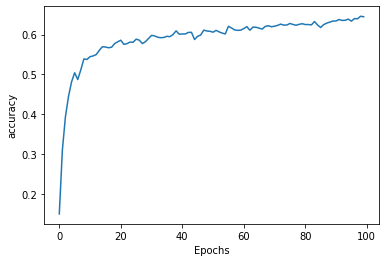

In [9]:
plot_graphs(history, 'accuracy')

## Finally Saving Tokenizer and Trained Model !

In [8]:
import pickle

with open('model_files/tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

model.save('model_files/lyrics_model.h5')